<a href="https://colab.research.google.com/github/MattLeRoi/new_project/blob/main/index.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bank

Dataset information -
The data is related to direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact with the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed.

1 - age (numeric)

2 - job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student",
"blue-collar","self-employed","retired","technician","services")

3 - marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)

4 - education (categorical: "unknown","secondary","primary","tertiary")

5 - default: has credit in default? (binary: "yes","no")

6 - balance: average yearly balance, in euros (numeric)

7 - housing: has housing loan? (binary: "yes","no")

8 - loan: has personal loan? (binary: "yes","no")

related with the last contact of the current campaign:

9 - contact: contact communication type (categorical: "unknown","telephone","cellular")

10 - day: last contact day of the month (numeric)

11 - month: last contact month of year (categorical: "jan", "feb", "mar", …, "nov", "dec")

12 - duration: last contact duration, in seconds (numeric)

other attributes:

13 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means 
client was not previously contacted)

15 - previous: number of contacts performed before this campaign and for this client (numeric)

16 - poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

Output variable (desired target):

17 - y - has the client subscribed a term deposit? (binary: "yes","no")

Missing Attribute Values: None

In [1]:
# !pip install lightgbm
# !pip install catboost
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from imblearn.over_sampling import SMOTE

import xgboost as xgb
from xgboost import XGBClassifier

import lightgbm as lgbm
from lightgbm import LGBMClassifier

from catboost import CatBoostClassifier, Pool, cv

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
df=pd.read_csv('bank-full.csv', delimiter=';')
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


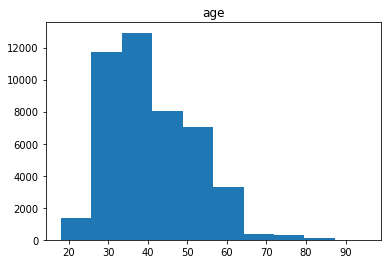

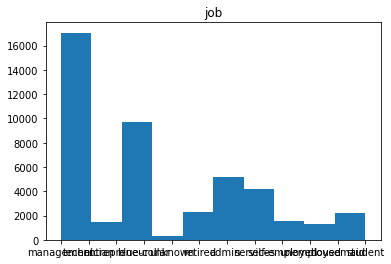

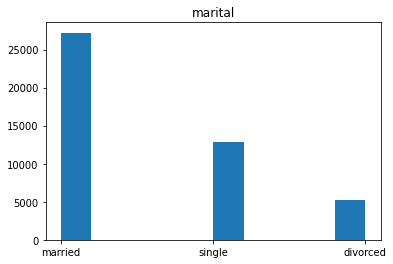

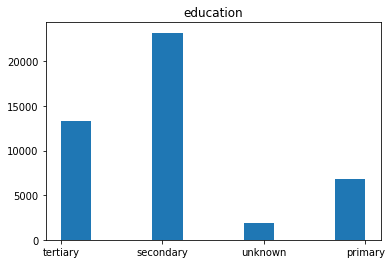

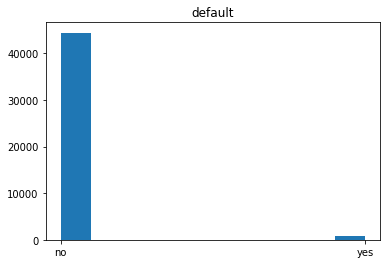

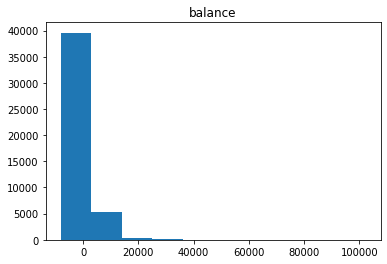

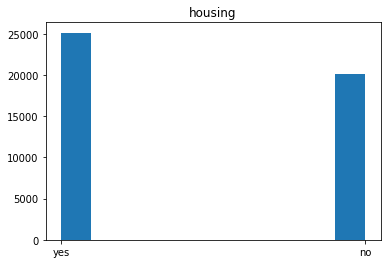

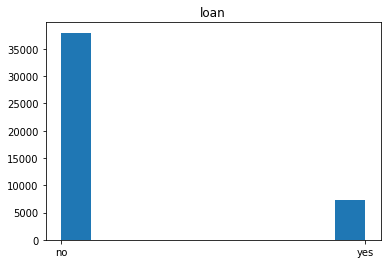

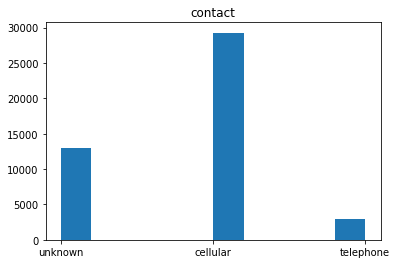

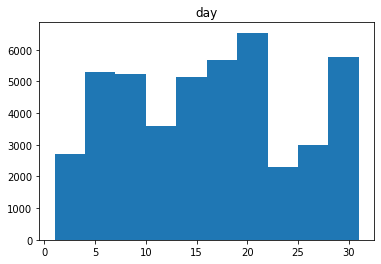

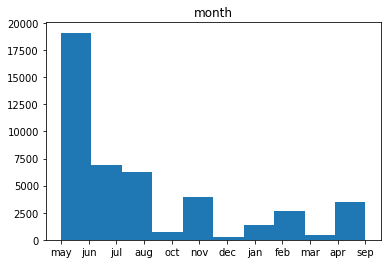

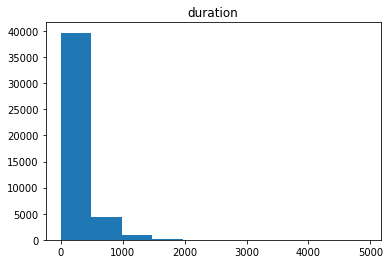

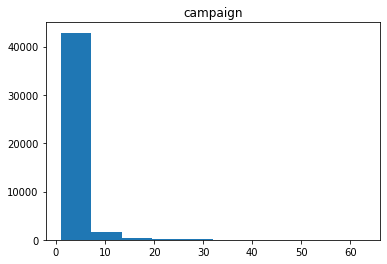

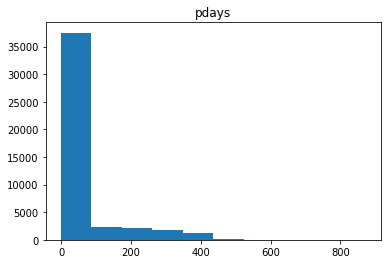

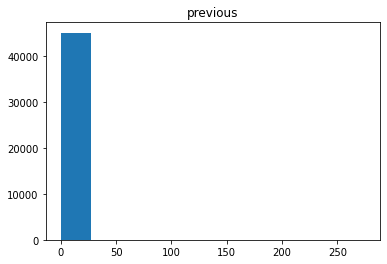

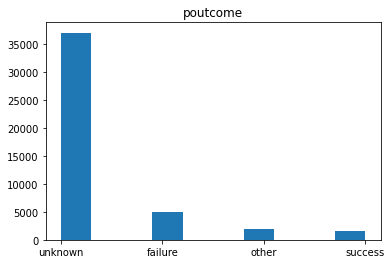

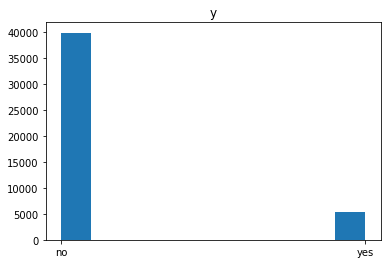

In [3]:
for col in df.columns:
    plt.figure()
    plt.title(col)
    plt.hist(df[col]);

In [4]:
y_n_counts = df.y.value_counts()
print(round(y_n_counts[1]/sum(y_n_counts)*100,2),'%')

11.7 %


In [5]:
X=df.drop(['y','pdays'], axis=1) # The -1 in pdays throws off the math. previous also functions as a flag for previously contacted
y = [1 if target_y_n == "yes" else 0 for target_y_n in df['y']]

In [6]:
categorical_features = ['day','job','marital','education','default','housing','loan','contact','month','poutcome']

X_encoded = pd.get_dummies(X, columns=categorical_features)
X_encoded

,age,balance,duration,campaign,previous,day_1,day_2,day_3,day_4,day_5,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,58,2143,261,1,0,False,False,False,False,True,...,False,False,True,False,False,False,False,False,False,True
1,44,29,151,1,0,False,False,False,False,True,...,False,False,True,False,False,False,False,False,False,True
2,33,2,76,1,0,False,False,False,False,True,...,False,False,True,False,False,False,False,False,False,True
3,47,1506,92,1,0,False,False,False,False,True,...,False,False,True,False,False,False,False,False,False,True
4,33,1,198,1,0,False,False,False,False,True,...,False,False,True,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,825,977,3,0,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,True
45207,71,1729,456,2,0,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,True
45208,72,5715,1127,5,3,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,False
45209,57,668,508,4,0,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,True


In [7]:
X_all_training,X_test_raw,y_all_training,y_test = train_test_split(X_encoded,y,random_state=42, test_size=.15) # 15% test set
X_train_raw,X_val_raw,y_train,y_val = train_test_split(X_all_training,y_all_training,random_state=42, test_size=.1/.85) # 10% validation set
X_val_raw

,age,balance,duration,campaign,previous,day_1,day_2,day_3,day_4,day_5,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
360,48,263,350,2,0,False,False,False,False,True,...,False,False,True,False,False,False,False,False,False,True
18751,43,5048,214,3,0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
15173,34,1,54,3,0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
20787,41,1545,183,2,0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
4517,33,163,135,1,0,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5239,31,360,395,1,0,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,True
37591,33,283,40,1,0,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,True
642,37,240,246,1,0,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,True
1718,22,2412,238,2,0,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,True


In [8]:
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train_raw), columns=X_encoded.columns)
X_val = pd.DataFrame(scaler.transform(X_val_raw), columns=X_encoded.columns)
X_test = pd.DataFrame(scaler.transform(X_test_raw), columns=X_encoded.columns)

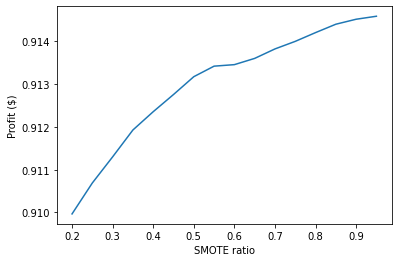

Wall time: 11 s


In [9]:
%%time
# This will loop through a range of ratios to feed into the SMOTE function to analyze the effect of oversampling the 
# churning customers to improve the sensitivity of the model. The results will be plotted to visualize the optimum value.

ratios = np.arange(.2,1,.05)
dollars_smote = []

for ratio in ratios:
    # Fit a model
    smote = SMOTE(sampling_strategy=ratio, random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train) 

    logreg_resample = LogisticRegression(fit_intercept=False, solver ='liblinear')
    logreg_resample.fit(X_train_resampled, y_train_resampled)
#     result = model_eval_no_print(logreg_resample,X_test.values,y_test)
    y_proba = logreg_resample.predict_proba(X_val)[:, 1]
    score = roc_auc_score(y_val, y_proba)
    dollars_smote.append(score)
    
fig, ax = plt.subplots()
ax.plot(ratios,dollars_smote,label='Profit ($)')
ax.set_ylabel('Profit ($)')
ax.set_xlabel('SMOTE ratio')
plt.show();

In [10]:
# Making the smote version run through the rest of the stuff

X_train = X_train_resampled
y_train = y_train_resampled

w/o smoting:

Model	Score
0	LogisticRegression(random_state=42)	0.911404
1	(DecisionTreeClassifier(max_features='sqrt', r...	0.926134
2	XGBClassifier(base_score=None, booster=None, c...	0.931322
3	LGBMClassifier(random_state=42, verbose=0)	0.933431
4	<catboost.core.CatBoostClassifier object at 0x...	0.934607


In [11]:
roc_results = pd.DataFrame(columns=['Model','Score'])
imp_factors = pd.DataFrame(columns=['LogisticRegression','DecisionTreeClassifier', 'XGBClassifier', 'LGBMClassifier', 'CatBoostClassifier'])
def add_score (roc_results,model_name):
    y_pred = model_name.predict(X_val)
    y_proba = model_name.predict_proba(X_val)[:, 1]
    score = roc_auc_score(y_val, y_proba)
    print("ROC-AUC:", score)
    new_row_data = {'Model':model_name, 'Score':score}
    roc_results.loc[len(roc_results)] = new_row_data
    
#     for cat in ('balance','duration','age'):
#         plt.figure(figsize=(10,6))
#         plt.scatter(X_val_raw[cat],y_proba*100)
#         plt.xlabel(cat)
#         plt.ylabel('Probability of signing (%)')
    
    return roc_results

### Logistic Regression

In [12]:
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)

add_score(roc_results,log_reg);


ROC-AUC: 0.9133975966008734


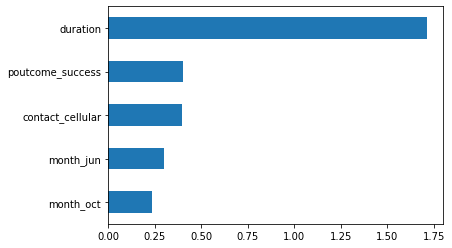

In [13]:
coefs = pd.Series(log_reg.coef_[0], index=X_train.columns).sort_values(ascending=False).head(5).sort_values(ascending=True)
coefs.plot(kind='barh');
imp_factors['LogisticRegression']=coefs.sort_values(ascending=False).head(5).index

### Random Forest

In [14]:
rf = RandomForestClassifier(
#     n_estimators=200,
#     max_depth=None,
    random_state=42)

rf.fit(X_train, y_train)


add_score(roc_results,rf)

ROC-AUC: 0.922561879877123


,Model,Score
0,LogisticRegression(random_state=42),0.913398
1,"(DecisionTreeClassifier(max_features='sqrt', r...",0.922562


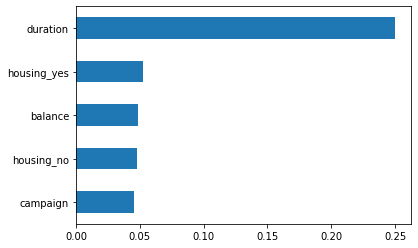

In [15]:
importances = pd.Series(rf.feature_importances_, index=X_train.columns)
importances.sort_values(ascending=False).head(5).sort_values(ascending=True).plot(kind='barh');
imp_factors['DecisionTreeClassifier']=importances.sort_values(ascending=False).head(5).index

### XGBoost

In [16]:
xgb_model = XGBClassifier(
#     n_estimators=200,
#     learning_rate=0.1,
#     max_depth=4,
    random_state=42,
#     use_label_encoder=False,
#     eval_metric='logloss'
)
xgb_model.fit(X_train, y_train)

add_score(roc_results,xgb_model)

ROC-AUC: 0.9305609500606147


,Model,Score
0,LogisticRegression(random_state=42),0.913398
1,"(DecisionTreeClassifier(max_features='sqrt', r...",0.922562
2,"XGBClassifier(base_score=None, booster=None, c...",0.930561


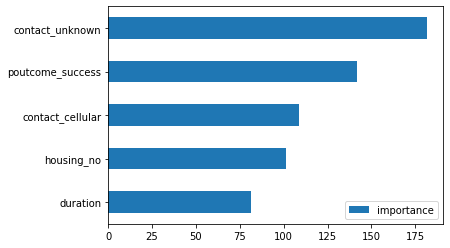

In [17]:
importance = xgb_model.get_booster().get_score(importance_type='gain')
importance_df = pd.DataFrame({'importance':list(importance.values())}, index=importance.keys())

importances=importance_df.sort_values(by='importance', ascending=True).tail(5)
importances.plot(kind='barh');
imp_factors['XGBClassifier']=importances.sort_values(by='importance',ascending=False).head(5).index

### Light GBM

In [18]:
lgbm_model = LGBMClassifier(
#     n_estimators=200,
#     learning_rate=0.1,
#     max_depth=-1,
    random_state=42,
    verbose=0
)
lgbm_model.fit(X_train, y_train)

add_score(roc_results,lgbm_model)

ROC-AUC: 0.93087064369196


,Model,Score
0,LogisticRegression(random_state=42),0.913398
1,"(DecisionTreeClassifier(max_features='sqrt', r...",0.922562
2,"XGBClassifier(base_score=None, booster=None, c...",0.930561
3,"LGBMClassifier(random_state=42, verbose=0)",0.930871


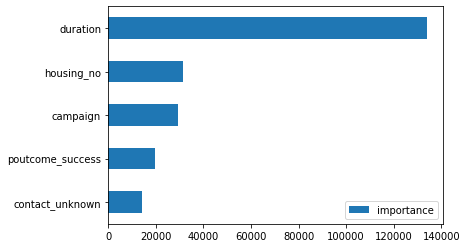

In [19]:
importance = lgbm_model.booster_.feature_importance(importance_type='gain')
feature_names = lgbm_model.feature_name_

importance_df = pd.DataFrame({'importance':importance}, index=feature_names)

importances=importance_df.sort_values(by='importance', ascending=True).tail(5)
importances.plot(kind='barh');
imp_factors['LGBMClassifier']=importances.sort_values(by='importance',ascending=False).head(5).index

### Cat Boost

In [20]:
cat_boost = CatBoostClassifier(
#     iterations=200,
#     learning_rate=0.1,
#     depth=6,
    random_seed=42,
    verbose=0
)
cat_boost.fit(X_train, y_train)

add_score(roc_results,cat_boost)

ROC-AUC: 0.9340158853461703


,Model,Score
0,LogisticRegression(random_state=42),0.913398
1,"(DecisionTreeClassifier(max_features='sqrt', r...",0.922562
2,"XGBClassifier(base_score=None, booster=None, c...",0.930561
3,"LGBMClassifier(random_state=42, verbose=0)",0.930871
4,<catboost.core.CatBoostClassifier object at 0x...,0.934016


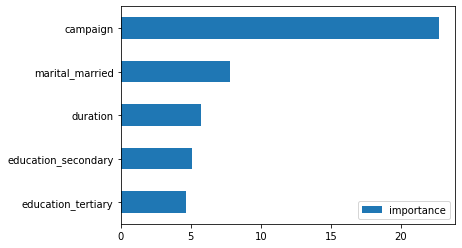

In [21]:
importance = cat_boost.get_feature_importance()
feature_names = X_train.columns

importance_df = pd.DataFrame({'importance':importance}, index=feature_names)

importances=importance_df.sort_values(by='importance', ascending=True).tail(5)
importances.plot(kind='barh');
imp_factors['CatBoostClassifier']=importances.sort_values(by='importance',ascending=False).head(5).index

In [22]:
imp_factors

,LogisticRegression,DecisionTreeClassifier,XGBClassifier,LGBMClassifier,CatBoostClassifier
0,duration,duration,contact_unknown,duration,campaign
1,poutcome_success,housing_yes,poutcome_success,housing_no,marital_married
2,contact_cellular,balance,contact_cellular,campaign,duration
3,month_jun,housing_no,housing_no,poutcome_success,education_secondary
4,month_oct,campaign,duration,contact_unknown,education_tertiary


In [23]:
factor_importance_results = pd.DataFrame(columns=['score'], index=X_train.columns)

for cat in X_train.columns:
    tot_factor_weight=0
    for col in imp_factors:
        ind_factor_weight = 5-imp_factors[imp_factors[col].str.contains(cat, case=False, na=False)].index
        if ind_factor_weight > 0:
            tot_factor_weight += ind_factor_weight
    if tot_factor_weight > 0:
        factor_importance_results.at[cat, 'score'] = tot_factor_weight[0]
    else: factor_importance_results.at[cat, 'score'] = 0

factor_importance_results.sort_values(by='score', ascending=False).head(5)

,score
duration,19
poutcome_success,10
campaign,9
housing_no,8
contact_cellular,6


In [24]:
all_encoded = X_encoded.copy()
all_encoded['y']=df['y']
for ind in factor_importance_results.sort_values(by='score', ascending=False).head(5).index:
    print(ind,(all_encoded[ind] == 1).sum())

duration 2
poutcome_success 1511
campaign 17544
housing_no 20081
contact_cellular 29285


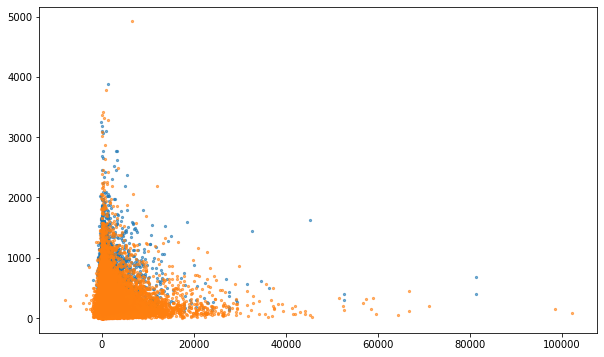

In [25]:
yes = all_encoded[all_encoded['y']=='yes']
no = all_encoded[all_encoded['y']!='yes']

plt.figure(figsize=(10,6))
plt.scatter(yes['balance'],yes['duration'], s=5, alpha=.6)
plt.scatter(no['balance'],no['duration'], s=5, alpha=.6);

## Grid search cv

In [26]:
%%time
cat_model = CatBoostClassifier(verbose=0, random_state=42)

param_grid = {
    'depth': [6, 8, 10],
    'learning_rate': [.03, 0.05, 0.07],
    'l2_leaf_reg': [1, 3],
#     'iterations': [300, 500, 1000]
}

grid = GridSearchCV(cat_model, param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)

Best params: {'depth': 10, 'l2_leaf_reg': 1, 'learning_rate': 0.03}
Wall time: 29min 4s


Best params: {'depth': 6, 'iterations': 1000, 'l2_leaf_reg': 5, 'learning_rate': 0.05}

In [27]:
gscv_model = grid.best_estimator_
add_score(roc_results,gscv_model)

ROC-AUC: 0.9327888806500085


,Model,Score
0,LogisticRegression(random_state=42),0.913398
1,"(DecisionTreeClassifier(max_features='sqrt', r...",0.922562
2,"XGBClassifier(base_score=None, booster=None, c...",0.930561
3,"LGBMClassifier(random_state=42, verbose=0)",0.930871
4,<catboost.core.CatBoostClassifier object at 0x...,0.934016
5,<catboost.core.CatBoostClassifier object at 0x...,0.932789


## Cat Boost built-in tuner

In [28]:
%%time
X_tuning = pd.concat([X_train,X_val], ignore_index=True)
y_tuning = y_train + y_val

train_pool = Pool(X_tuning, label=y_tuning)

params = {
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'random_seed': 42,
    'verbose': False,
    'early_stopping_rounds': 50,
    'iterations': 1000,      # upper limit; early stopping will choose fewer
}

cv_results = cv(
    params=params,
    pool=train_pool,
    fold_count=5,
    shuffle=True,
    partition_random_seed=42,
    plot=True   # shows learning curve in Colab / Jupyter
)


print(cv_results.head())

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.989354548
bestIteration = 999

Training on fold [1/5]

bestTest = 0.9890349642
bestIteration = 999

Training on fold [2/5]

bestTest = 0.9894260075
bestIteration = 999

Training on fold [3/5]

bestTest = 0.989543955
bestIteration = 999

Training on fold [4/5]

bestTest = 0.988967014
bestIteration = 986

   iterations  test-AUC-mean  test-AUC-std  test-Logloss-mean  \
0           0       0.904762      0.004029           0.663932   
1           1       0.913118      0.002649           0.636078   
2           2       0.916557      0.002420           0.613055   
3           3       0.924866      0.005752           0.592087   
4           4       0.927152      0.005362           0.573671   

   test-Logloss-std  train-Logloss-mean  train-Logloss-std  
0          0.001688            0.663906           0.001423  
1          0.001800            0.636024           0.001308  
2          0.002761            0.612935           0.002197  
3          0.004200    

In [29]:
%%time
# Best iteration
best_iter = len(cv_results)
best_auc = cv_results['test-AUC-mean'].max()

print(f"Best iteration: {best_iter}")
print(f"Best CV AUC: {best_auc:.4f}")

depths = [7, 8, 10]
learning_rates = [0.03, 0.05, 0.07]
l2_leaf_regs = [1, 3]

results = []

for d in depths:
    for lr in learning_rates:
        for l2 in l2_leaf_regs:
            params.update({'depth': d, 'learning_rate': lr, 'l2_leaf_reg':l2})
            cv_data = cv(params=params, pool=train_pool, fold_count=5, shuffle=True, verbose=False)
            best_auc = cv_data['test-AUC-mean'].max()
            results.append((d, lr, l2, best_auc))

results_df = pd.DataFrame(results, columns=['depth', 'learning_rate', 'l2_leaf_reg', 'AUC'])
print(results_df.sort_values('AUC', ascending=False))

Best iteration: 1000
Best CV AUC: 0.9893
Training on fold [0/5]

bestTest = 0.9901518544
bestIteration = 998

Training on fold [1/5]

bestTest = 0.9887976543
bestIteration = 999

Training on fold [2/5]

bestTest = 0.9894987295
bestIteration = 999

Training on fold [3/5]

bestTest = 0.9900440809
bestIteration = 993

Training on fold [4/5]

bestTest = 0.989932178
bestIteration = 999

Training on fold [0/5]

bestTest = 0.9900431563
bestIteration = 999

Training on fold [1/5]

bestTest = 0.9885120482
bestIteration = 999

Training on fold [2/5]

bestTest = 0.989446509
bestIteration = 999

Training on fold [3/5]

bestTest = 0.9899872565
bestIteration = 997

Training on fold [4/5]

bestTest = 0.9898437721
bestIteration = 999

Training on fold [0/5]

bestTest = 0.9904614433
bestIteration = 988

Training on fold [1/5]

bestTest = 0.9889793944
bestIteration = 933

Training on fold [2/5]

bestTest = 0.9900313119
bestIteration = 986

Training on fold [3/5]

bestTest = 0.9904791665
bestIteration = 

In [30]:
%%time
best_params = {
    'depth': 10,
    'learning_rate': 0.05,
    'iterations': best_iter,
    'l2_leaf_reg': 1,
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'random_seed': 42,
}

final_model = CatBoostClassifier(**best_params)
final_model.fit(X_train, y_train, verbose=100);

0:	total: 129ms	remaining: 2m 9s
100:	total: 12s	remaining: 1m 46s
200:	total: 23.8s	remaining: 1m 34s
300:	total: 35.5s	remaining: 1m 22s
400:	total: 47.4s	remaining: 1m 10s
500:	total: 59.4s	remaining: 59.1s
600:	total: 1m 11s	remaining: 47.2s
700:	total: 1m 22s	remaining: 35.4s
800:	total: 1m 34s	remaining: 23.5s
900:	total: 1m 46s	remaining: 11.7s
999:	total: 1m 58s	remaining: 0us
Wall time: 1min 58s


In [31]:
%%time
best_params = {
    'depth': 8,
    'learning_rate': 0.05,
    'iterations': best_iter,
    'l2_leaf_reg': 1,
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'random_seed': 42,
}

final_model = CatBoostClassifier(**best_params)
final_model.fit(X_train, y_train, verbose=100);

0:	total: 45.9ms	remaining: 45.8s
100:	total: 2.72s	remaining: 24.2s
200:	total: 5.36s	remaining: 21.3s
300:	total: 8.01s	remaining: 18.6s
400:	total: 10.7s	remaining: 16s
500:	total: 13.3s	remaining: 13.3s
600:	total: 16s	remaining: 10.6s
700:	total: 18.7s	remaining: 7.98s
800:	total: 21.4s	remaining: 5.31s
900:	total: 24s	remaining: 2.64s
999:	total: 26.7s	remaining: 0us
Wall time: 27 s


In [32]:
add_score(roc_results,final_model)

ROC-AUC: 0.9332974353542131


,Model,Score
0,LogisticRegression(random_state=42),0.913398
1,"(DecisionTreeClassifier(max_features='sqrt', r...",0.922562
2,"XGBClassifier(base_score=None, booster=None, c...",0.930561
3,"LGBMClassifier(random_state=42, verbose=0)",0.930871
4,<catboost.core.CatBoostClassifier object at 0x...,0.934016
5,<catboost.core.CatBoostClassifier object at 0x...,0.932789
6,<catboost.core.CatBoostClassifier object at 0x...,0.933297


In [33]:
%%time
for model_name in [log_reg,rf,xgb_model,lgbm_model,cat_boost, final_model]:
    y_pred = model_name.predict(X_test)
    y_proba = model_name.predict_proba(X_test)[:, 1]
    score = roc_auc_score(y_test, y_proba)
    print(model_name," ROC-AUC:", score)

LogisticRegression(random_state=42)  ROC-AUC: 0.9088779282289939
RandomForestClassifier(random_state=42)  ROC-AUC: 0.9203081293165334
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)  ROC-AUC: 0.9283028442706142
LGBMClassifier(random_state=42, verbose=0)  ROC-AUC: 0.9284963404873301
<catboost.core.

In [34]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

y_pred = final_model.predict(X_test)
y_proba = final_model.predict_proba(X_test)[:, 1]

print('Accuracy:',round(accuracy_score(y_test,y_pred)*100,2),'%')
print(confusion_matrix(y_test,y_pred))
print(roc_score(y_test,y_preda))


Accuracy: 90.75 %
[[5712  258]
 [ 369  443]]


NameError: name 'roc_score' is not defined

look at two sets - previously contacted vs not? 
check number of each